#### Se usará la base de datos datos_credit_balanced_sin_correlación.csv

In [1]:
import pandas as pd

#### Para aumentar la velocidad de lectura del banco de datos, se guardará el csv en formato pkl que es considerablemente más rápido. De ahora en adelante se importará desde ese tipo de archivo

In [2]:
from rich.console import Console
from rich import print
console = Console()

#### Clasificador K-NN

In [3]:
preprocessed_data = pd.read_pickle("./pickled/creditcard_preprocessed.pkl")

#### Definimos los atributos y la clase objetivo para separar los datos en entrenamiento y prueba

In [4]:
FEATURES_PRE = preprocessed_data.drop('Class', axis=1)
TARGET_PRE = preprocessed_data['Class']
FEATURES_PRE = pd.get_dummies(FEATURES_PRE)

In [5]:
from sklearn.model_selection import train_test_split

FEATURES_TRAIN_PRE, FEATURES_TEST_PRE, TARGET_TRAIN_PRE, TARGET_TEST_PRE = train_test_split(FEATURES_PRE, TARGET_PRE, test_size=0.3, random_state=42)

#### Sacamos la k óptima

In [6]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

#### Esto tarda una cantidad considerable de tiempo (a mí me tardo 25 minutos para 1). Si no necesitas que use el 100% de la CPU, quita el argumento 'n_jobs' o ponlo a 1 ó 2, sin embargo esto hará que tarde más.

Minimum error:- 0.0005033478484805918 at K = 2

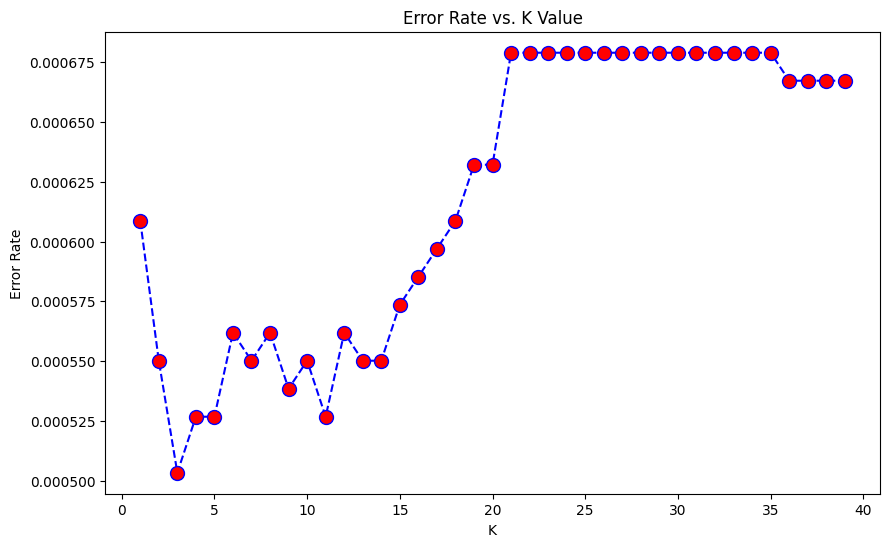

In [7]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(FEATURES_TRAIN_PRE,TARGET_TRAIN_PRE)
    pred_i = knn.predict(FEATURES_TEST_PRE)
    error_rate.append(np.mean(pred_i != TARGET_TEST_PRE))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)) + 1)

Maximum accuracy:- 0.9993257455317794 at K = 37

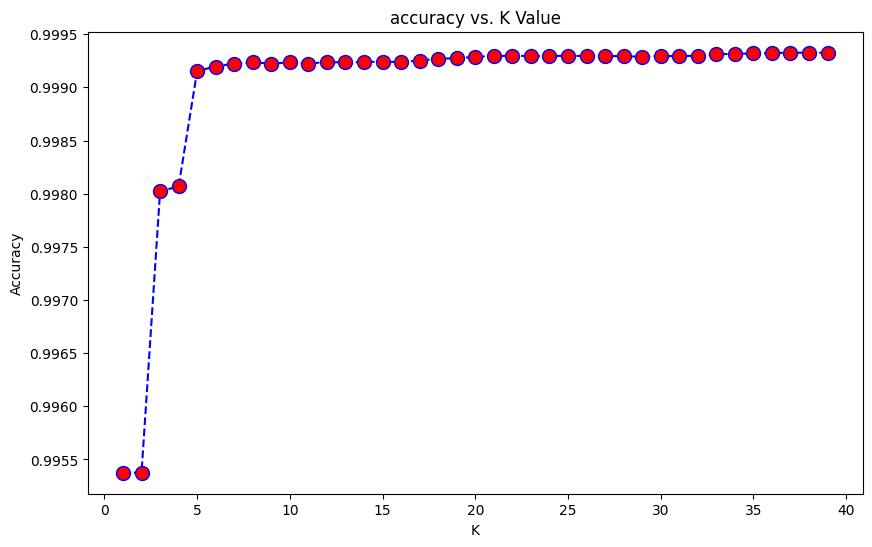

In [8]:
acc = []
from sklearn import metrics
for i in range(1, 40):
    neigh = KNeighborsClassifier(n_neighbors=i, weights='distance').fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
    yhat = neigh.predict(FEATURES_TEST_PRE)
    acc.append(cross_val_score(neigh, FEATURES_PRE, TARGET_PRE, cv=10, scoring='accuracy').mean())
    
plt.figure(figsize=(10,6))
plt.plot(range(1, 40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-", max(acc),"at K =", acc.index(max(acc)) + 1)

Nos quedamos con k = 5

In [19]:
neigh = KNeighborsClassifier(n_neighbors=6, weights='distance').fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
yhat = neigh.predict(FEATURES_TEST_PRE)
accuracy = cross_val_score(neigh, FEATURES_PRE, TARGET_PRE, cv=10, scoring='accuracy')

In [18]:
from sklearn.metrics import confusion_matrix

print(accuracy.mean())

conf_matrix = confusion_matrix(TARGET_TEST_PRE, yhat)
print('Confusion matrix: \n', conf_matrix)

0.9980685466102965

Confusion matrix: 
 [[85302     4]
 [   39    83]]

#### Clasificador Naive Bayes

Clasificador Gaussiano, averiguamos el mejor modelo

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

gnb = GaussianNB()
param_grid = {'var_smoothing': np.arange(0.0, 10.1, 0.1)}
grid = GridSearchCV(gnb, param_grid, cv=5)
grid.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)

print("Best var_smoothing value: ", grid.best_estimator_.var_smoothing)


Best var_smoothing value:  2.6

In [31]:
from sklearn.metrics import confusion_matrix

gnb_best = grid.best_estimator_.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)

y_pred = gnb_best.predict(FEATURES_TEST_PRE)
accuracy = cross_val_score(gnb_best, FEATURES_PRE, TARGET_PRE, cv=10, scoring='accuracy')
conf_matrix = confusion_matrix(TARGET_TEST_PRE, y_pred)

print("Filas totales: %d \nFilas no clasificadas correctamente: %d" % (FEATURES_TEST_PRE.shape[0], (TARGET_TEST_PRE != y_pred).sum()))
print("Score: ", accuracy.mean())
print('Matriz de confusión:')
print(conf_matrix)

Filas totales: 85428 
Filas no clasificadas correctamente: 104

Score:  0.998528579679131

Matriz de confusión:

[[85301     5]
 [   99    23]]

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtc = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': [3, 5, 7, 9],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 2, 3, 4]}

grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='recall')
grid_search.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
best_dtc = grid_search.best_estimator_
y_pred = best_dtc.predict(FEATURES_TEST_PRE)

accuracy = accuracy_score(TARGET_TEST_PRE, y_pred)
precision = precision_score(TARGET_TEST_PRE, y_pred)
recall = recall_score(TARGET_TEST_PRE, y_pred)
f1 = f1_score(TARGET_TEST_PRE, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Best hyperparameters:", grid_search.best_params_)

grid_search.best_estimator_.fit(FEATURES_TRAIN_PRE, TARGET_TRAIN_PRE)
accuracy = cross_val_score(grid_search.best_estimator_, FEATURES_PRE, TARGET_PRE, cv=10, scoring='accuracy')
conf_matrix = confusion_matrix(TARGET_TEST_PRE, y_pred)

print("Filas totales: %d \nFilas no clasificadas correctamente: %d" % (FEATURES_TEST_PRE.shape[0], (TARGET_TEST_PRE != y_pred).sum()))
print("Score: ", accuracy.mean())
print('Matriz de confusión:')
print(conf_matrix)

Accuracy: 0.9994498290958468

Precision: 0.9120879120879121

Recall: 0.680327868852459

F1-score: 0.7793427230046949

Best hyperparameters:
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}

Filas totales: 85428 
Filas no clasificadas correctamente: 47

Score:  0.9514854594679857

Matriz de confusión:

[[85298     8]
 [   39    83]]